In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np

# random forest functions
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

# Metric
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model selection grid search
from sklearn.model_selection import train_test_split, GridSearchCV

# feature importance
from sklearn.inspection import permutation_importance

import time

from shuffle import shuffle_df

import warnings
warnings.filterwarnings("ignore")
print('Version of sklearn: ' + sklearn.__version__)

Version of sklearn: 1.5.2


# Read in data

In [5]:
path = 'data'

X_fps_train = pd.read_csv(f'{path}/X_fps_train.csv', index_col = 0)
X_embed_train = pd.read_csv(f'{path}/X_embed_train.csv', index_col = 0)
X_join_train = pd.concat([X_fps_train, X_embed_train], axis = 1)
y_train0 = pd.read_csv(f"{path}/y_train.csv", index_col = 0)

X_fps_train, y_train = shuffle_df(trainX_df = X_fps_train, trainY_df = y_train0)
X_embed_train, y_train = shuffle_df(trainX_df = X_embed_train, trainY_df = y_train0)
X_join_train, y_train = shuffle_df(trainX_df = X_join_train, trainY_df = y_train0)

X_fps_test = pd.read_csv(f'{path}/X_fps_public_test.csv', index_col = 0)
X_embed_test = pd.read_csv(f'{path}/X_embed_public_test.csv', index_col = 0)
X_join_test = pd.concat([X_fps_test, X_embed_test], axis = 1)
y_test = pd.read_csv(f"{path}/y_public_test.csv", index_col = 0)

X_fps_test, X_embed_test, X_join_test, y_test = np.array(X_fps_test), np.array(X_embed_test), np.array(X_join_test), y_test.iloc[:, 0].to_numpy()

n, p_fps = X_fps_train.shape
n, p_embed = X_embed_train.shape
n, p_join = X_join_train.shape

# XGBoost Training
## 1. Initial Model Exploration
We started with a moderate tree depth (max_depth = 20) and examined how risk varied with the number of trees (n_estimators).

As out-of-bag risk can be unstable with small and varying samples, we used 4:1 train-validation split to monitor train and validation MSE. Based on this, we will select an appropriate n_estimators to balance computational cost and generalisability in the following grid-search hyperparameter tuning.


## explore appropriate n_estimators (num of trees)

In [14]:
import joblib

models_fps, models_embed = {}, {}
Bs = [30, 50, 100, 200, 300]

for i, B in enumerate(Bs):
    print('B =', B)
    regr_RF_fps = RandomForestRegressor(n_estimators=B, oob_score=True, max_depth=20, random_state = 40)
    regr_RF_fps.fit(X_fps_train[:n//5*4, :], y_train[:n//5*4])

    regr_RF_embed = RandomForestRegressor(n_estimators=B, oob_score=True, max_depth=20, random_state = 10)
    regr_RF_embed.fit(X_embed_train[:n//5*4, :], y_train[:n//5*4])
    
    # store the model in a dictionary for later
    models_fps[B] = regr_RF_fps
    models_embed[B] = regr_RF_embed

B = 30
B = 50
B = 100
B = 200
B = 300


In [41]:
models_join = {}
Bs_join = [50, 100, 200, 300, 350]

for i, B in enumerate(Bs_join):
    print('B =', B)

    regr_RF_join = RandomForestRegressor(n_estimators=B, oob_score=True, max_depth=20, random_state = 40)
    regr_RF_join.fit(X_join_train[:n//5*4, :], y_train[:n//5*4])

    # store the model in a dictionary for later
    models_join[B] = regr_RF_join

B = 50
B = 100
B = 200
B = 300
B = 350


In [11]:
def get_train_validation_errors(Bs, models, X, y):
    R_train = np.zeros(shape=(len(Bs)))
    R_vali = np.zeros(shape=(len(Bs)))
    
    # Record error metrics
    for (i, mod) in enumerate(list(models.values())):
        R_train[i] = mean_squared_error(y[:n//5*4], mod.predict(X[:n//5*4, :])) # Training error
        R_vali[i] = mean_absolute_error(y[n//5*4:], mod.predict(X[n//5*4:, :])) # validation error
        
    return R_train, R_vali

In [43]:
R_train_fps, R_vali_fps = get_train_validation_errors(Bs, models_fps, X_fps_train, y_train)
R_train_embed, R_vali_embed = get_train_validation_errors(Bs, models_embed, X_embed_train, y_train)
R_train_join, R_vali_join = get_train_validation_errors(Bs, models_join, X_join_train, y_train)

In [123]:
R_oob = np.zeros(shape=(len(Bs)))
R_train = np.zeros(shape=(len(Bs)))
R_test = np.zeros(shape=(len(Bs)))

# Record error metrics
for (i, mod) in enumerate(list(models.values())):
    R_oob[i] = mean_squared_error(y[:n//5*4], mod.oob_prediction_)  # Out-of-bag error
    R_train[i] = mean_squared_error(y[:n//5*4], mod.predict(X[:n//5*4, :])) # Training error
    R_test[i] = mean_absolute_error(y[n//5*4:], mod.predict(X[n//5*4:, :])) # validation error

In [16]:
def vis_train_validation_errors(Bs, R_train, R_vali, data_name):
    fig, ax1 = plt.subplots(figsize=(6,5))

    ax1.plot(Bs, R_train, 'o-', color='mediumblue', label='Train MSE')
    ax1.set_xlabel('Number of Trees (n_estimators)', size=18)
    ax1.set_ylabel('Train MSE', color='mediumblue', size=20)
    ax1.tick_params(axis='y', labelcolor='mediumblue', labelsize = 15)
    ax1.tick_params(axis='x', labelsize = 15)
    
    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.plot(Bs, R_vali, 'o-', color='tab:red', label='Validation MSE')
    ax2.set_ylabel('Validation MSE', color='tab:red', size=20)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize = 15)
    ax2.tick_params(axis='x', labelsize = 15)
    
    plt.title(data_name, size = 20)
    plt.grid()
    # plt.savefig(f'{vis_path}/RF_{data_name}_selectB_dualRisk.png', bbox_inches='tight')
    plt.show()

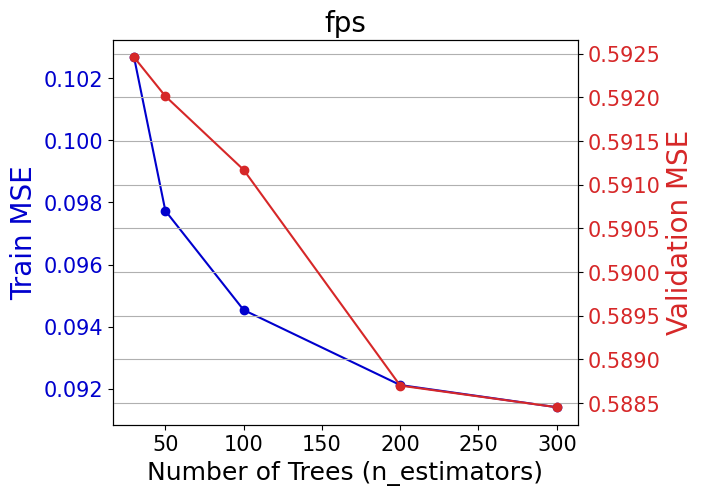

In [17]:
vis_train_validation_errors(Bs, R_train_fps, R_vali_fps, "fps")

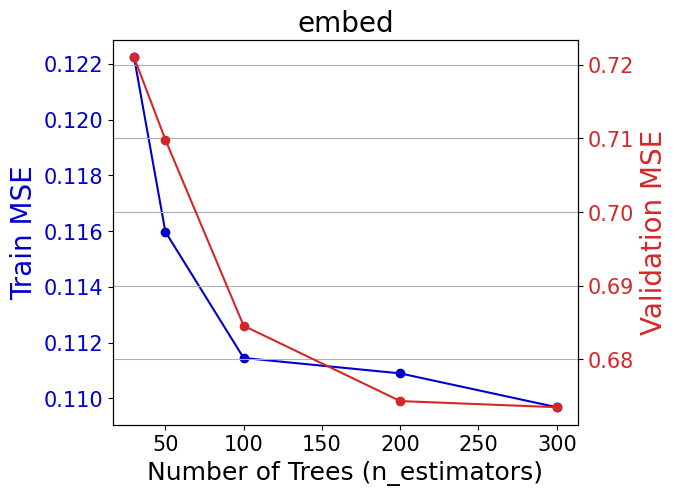

In [19]:
vis_train_validation_errors(Bs, R_train_embed, R_vali_embed, "embed")

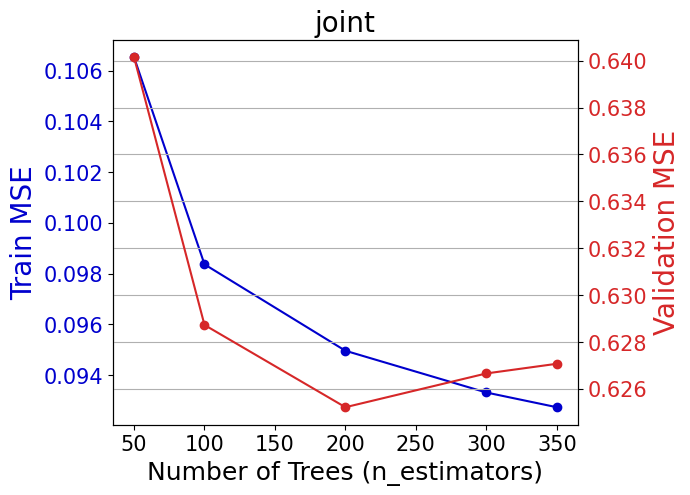

In [44]:
vis_train_validation_errors(Bs_join, R_train_join, R_vali_join, "joint")

**choose number of trees (n_estimators) = 200, to keep the generalisability and also save computation**

## 2. Hyperparameter Tuning (max depths, max features)
Following the same approach as SVR, grid search based on validation MSE was performed on two key tree-related parameters:
1. max_depth: the maximum depth of each tree, which controls model complexity;
2. max_features: the proportion of features considered at each split, influencing the
diversity among trees in the forest.

In [45]:
# Define parameter grid and model
param_grid = {
    'max_depth': [15,25,35],
    'max_features': [0.3,0,5,0.8]
}

regr_RF_fps = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=666)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_fps = GridSearchCV(regr_RF_fps, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           verbose=5)

# Fit the model
grid_search_fps.fit(X_fps_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_depth=15, max_features=0.3;, score=-0.577 total time=   1.9s
[CV 2/5] END ...max_depth=15, max_features=0.3;, score=-0.572 total time=   1.7s
[CV 3/5] END ...max_depth=15, max_features=0.3;, score=-0.638 total time=   1.7s
[CV 4/5] END ...max_depth=15, max_features=0.3;, score=-0.542 total time=   1.7s
[CV 5/5] END ...max_depth=15, max_features=0.3;, score=-0.594 total time=   1.7s
[CV 1/5] END ........max_depth=15, max_features=0;, score=nan total time=   0.0s
[CV 2/5] END ........max_depth=15, max_features=0;, score=nan total time=   0.0s
[CV 3/5] END ........max_depth=15, max_features=0;, score=nan total time=   0.0s
[CV 4/5] END ........max_depth=15, max_features=0;, score=nan total time=   0.0s
[CV 5/5] END ........max_depth=15, max_features=0;, score=nan total time=   0.0s
[CV 1/5] END .....max_depth=15, max_features=5;, score=-0.843 total time=   0.3s
[CV 2/5] END .....max_depth=15, max_features=5;,

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, oob_score=True,
                                             random_state=666),
             param_grid={'max_depth': [15, 25, 35],
                         'max_features': [0.3, 0, 5, 0.8]},
             scoring='neg_mean_squared_error', verbose=5)

In [47]:
# Define parameter grid and model
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'max_features': [0.1, 0.5, 0.8]
}

regr_RF_embed = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=666)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_embed = GridSearchCV(regr_RF_embed, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           verbose=5)

# Fit the model
grid_search_embed.fit(X_embed_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....max_depth=5, max_features=0.1;, score=-0.869 total time=   1.0s
[CV 2/5] END ....max_depth=5, max_features=0.1;, score=-0.886 total time=   1.0s
[CV 3/5] END ....max_depth=5, max_features=0.1;, score=-1.043 total time=   1.0s
[CV 4/5] END ....max_depth=5, max_features=0.1;, score=-0.854 total time=   0.9s
[CV 5/5] END ....max_depth=5, max_features=0.1;, score=-0.879 total time=   1.0s
[CV 1/5] END ....max_depth=5, max_features=0.5;, score=-0.811 total time=   4.0s
[CV 2/5] END ....max_depth=5, max_features=0.5;, score=-0.891 total time=   4.3s
[CV 3/5] END ....max_depth=5, max_features=0.5;, score=-0.987 total time=   4.0s
[CV 4/5] END ....max_depth=5, max_features=0.5;, score=-0.804 total time=   4.0s
[CV 5/5] END ....max_depth=5, max_features=0.5;, score=-0.806 total time=   5.6s
[CV 1/5] END ....max_depth=5, max_features=0.8;, score=-0.822 total time=   6.2s
[CV 2/5] END ....max_depth=5, max_features=0.8;,

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, oob_score=True,
                                             random_state=666),
             param_grid={'max_depth': [5, 10, 20, 30],
                         'max_features': [0.1, 0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=5)

In [50]:
# Define parameter grid and model
param_grid = {
    'max_depth': [10, 20, 30],
    'max_features': [0.0625, 0.1, 0.2, 0.5]
}

regr_RF_join = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=666)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_join = GridSearchCV(regr_RF_join, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           verbose=5)

# Fit the model
grid_search_join.fit(X_join_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=10, max_features=0.0625;, score=-0.698 total time=   1.5s
[CV 2/5] END max_depth=10, max_features=0.0625;, score=-0.704 total time=   1.8s
[CV 3/5] END max_depth=10, max_features=0.0625;, score=-0.795 total time=   1.6s
[CV 4/5] END max_depth=10, max_features=0.0625;, score=-0.663 total time=   1.5s
[CV 5/5] END max_depth=10, max_features=0.0625;, score=-0.687 total time=   1.4s
[CV 1/5] END ...max_depth=10, max_features=0.1;, score=-0.680 total time=   2.1s
[CV 2/5] END ...max_depth=10, max_features=0.1;, score=-0.699 total time=   2.1s
[CV 3/5] END ...max_depth=10, max_features=0.1;, score=-0.793 total time=   2.1s
[CV 4/5] END ...max_depth=10, max_features=0.1;, score=-0.659 total time=   3.5s
[CV 5/5] END ...max_depth=10, max_features=0.1;, score=-0.672 total time=   2.1s
[CV 1/5] END ...max_depth=10, max_features=0.2;, score=-0.674 total time=   3.9s
[CV 2/5] END ...max_depth=10, max_features=0.2;,

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, oob_score=True,
                                             random_state=666),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [0.0625, 0.1, 0.2, 0.5]},
             scoring='neg_mean_squared_error', verbose=5)

In [46]:
best_rf_fps = grid_search_fps.best_estimator_
print("max_depth:", best_rf_fps.max_depth, "  max_features:", best_rf_fps.max_features)
print('Out-of-bag risk =', mean_squared_error(y_train, best_rf_fps.oob_prediction_))

max_depth: 25   max_features: 0.8
Out-of-bag risk = 0.5433883192156312


In [48]:
best_rf_embed = grid_search_embed.best_estimator_
print("max_depth:", best_rf_embed.max_depth, "  max_features:", best_rf_embed.max_features)
print('Out-of-bag risk =', mean_squared_error(y_train, best_rf_embed.oob_prediction_))

max_depth: 30   max_features: 0.5
Out-of-bag risk = 0.739147565838318


In [51]:
best_rf_join = grid_search_join.best_estimator_
print("max_depth:", best_rf_join.max_depth, "  max_features:", best_rf_join.max_features)
print('Out-of-bag risk =', mean_squared_error(y_train, best_rf_join.oob_prediction_))

max_depth: 30   max_features: 0.2
Out-of-bag risk = 0.651570265212269


In [53]:
def evaluate(X_train, y_train, X_test, y_test, n_estimators, max_depth, max_features):
    mse_ls = []
    mae_ls = []
    time_ls = []
    
    for seed in [111, 222, 333, 444, 555]:
    
        t0 = time.time()
        rf_eval = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, max_depth = max_depth, max_features = max_features, random_state=seed)
        rf_eval.fit(X_train, y_train)
        delta_t = time.time() - t0
    
        # Evaluate on the public test set
        y_pred_test = rf_eval.predict(X_test)
        mse_ls.append(mean_squared_error(y_test, y_pred_test))
        mae_ls.append(mean_absolute_error(y_test, y_pred_test))
        time_ls.append(delta_t)
    print("Performance on Public Test Set: Mean (SE)")
    print(f'Mean Squared Error: {round(np.mean(mse_ls), 4)} ({round(np.std(mse_ls), 4)})')
    print(f'Mean Absolute Error: {round(np.mean(mae_ls), 4)} ({round(np.std(mae_ls), 4)})')
    print(f'Time: {round(np.mean(time_ls), 4)} ({round(np.std(time_ls), 4)})')


print("################################")
print("Random Forest Performance on Fps data:")
evaluate(X_fps_train, y_train, X_fps_test, y_test, 
         n_estimators = 200,
         max_depth = 25, 
         max_features = 0.8)

print("################################")
print("Random Forest Performance on Embed data:")
evaluate(X_embed_train, y_train, X_embed_test, y_test, 
         n_estimators = 200,
         max_depth = 30, 
         max_features = 0.5)

print("################################")
print("Random Forest Performance on joint data:")
evaluate(X_join_train, y_train, X_join_test, y_test, 
         n_estimators = 200,
         max_depth = 30, 
         max_features = 0.2)

################################
Random Forest Performance on Fps data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.7562 (0.0157)
Mean Absolute Error: 0.7282 (0.005)
Time: 5.7353 (0.3636)
################################
Random Forest Performance on Embed data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.8452 (0.0139)
Mean Absolute Error: 0.7561 (0.0064)
Time: 10.504 (0.2949)
################################
Random Forest Performance on joint data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.7987 (0.0151)
Mean Absolute Error: 0.7344 (0.0062)
Time: 6.4226 (0.1224)


# Interpretation - Feature Importance

In [57]:
fps_importances = permutation_importance(best_rf_fps, X_fps_train, y_train, n_repeats=5, random_state=0)
embed_importances = permutation_importance(best_rf_embed, X_embed_train, y_train, n_repeats=5, random_state=0)

In [59]:
fps_importances = fps_importances.importances_mean
embed_importances = embed_importances.importances_mean

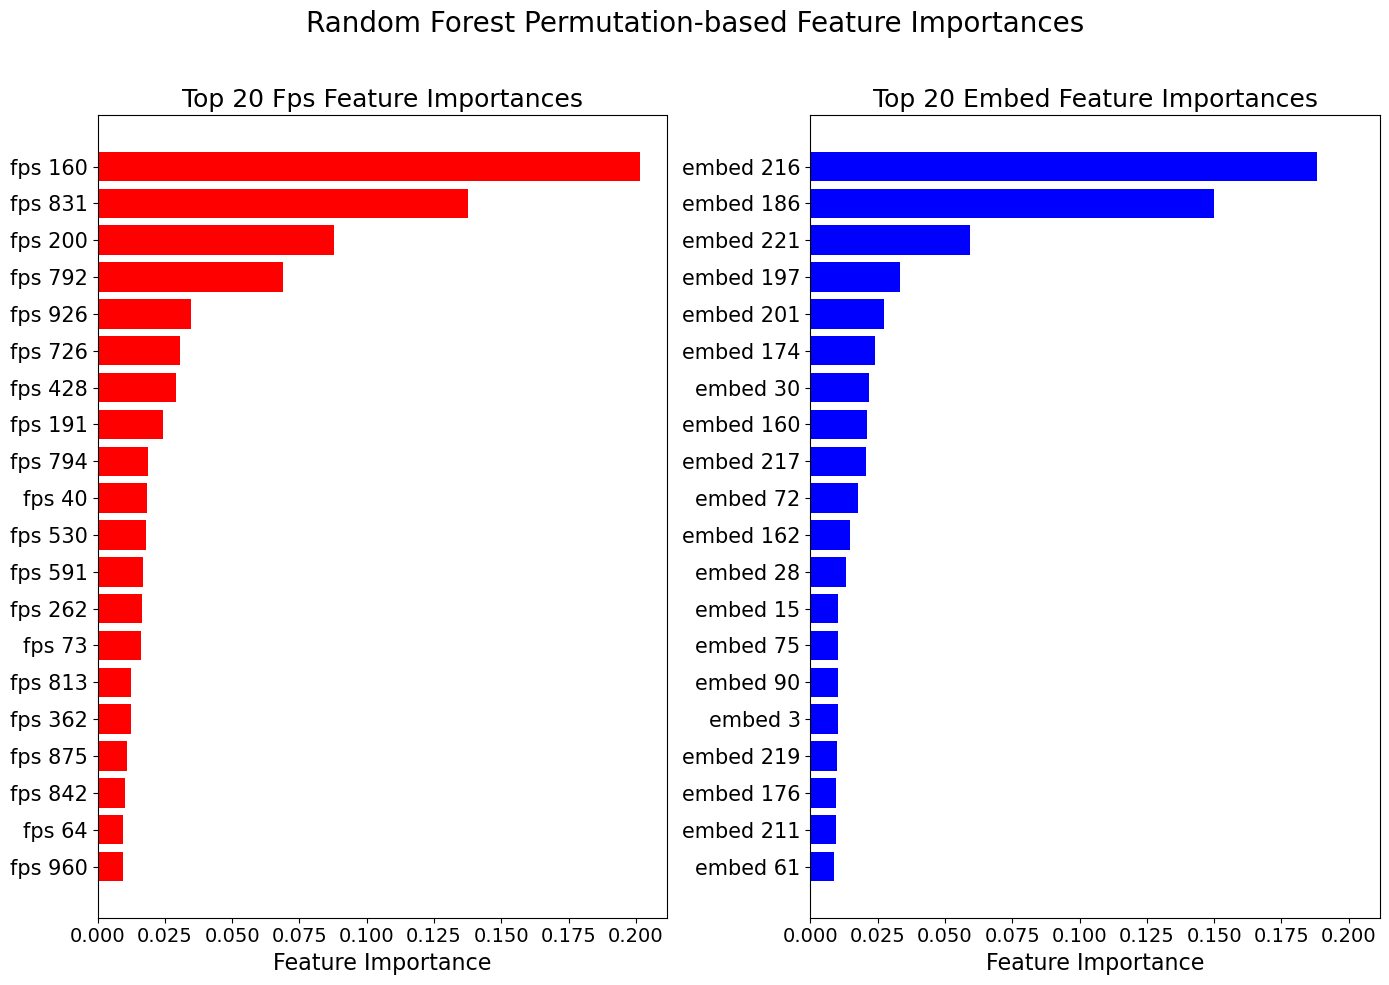

In [60]:
fps_variable_names = [f'fps {i}' for i in range(1024)]
embed_variable_names = [f'embed {i}' for i in range(224)]

top_n = 20

# FPS feature importance
sorted_idx_fps = np.argsort(fps_importances)
top_n_idx_fps = sorted_idx_fps[-top_n:]

# Embed feature importance
sorted_idx_embed = np.argsort(embed_importances)
top_n_idx_embed = sorted_idx_embed[-top_n:]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharex=True)
fig.suptitle("Random Forest Permutation-based Feature Importances", fontsize=20)

# FPS plot
axes[0].barh(np.array(fps_variable_names)[top_n_idx_fps], fps_importances[top_n_idx_fps], color='red')
axes[0].set_title("Top {} Fps Feature Importances".format(top_n), fontsize=18)
axes[0].set_xlabel("Feature Importance", size = 16)
axes[0].tick_params(axis='x', labelsize=14) 
axes[0].tick_params(axis='y', labelsize=15)

# Embed plot
axes[1].barh(np.array(embed_variable_names)[top_n_idx_embed], embed_importances[top_n_idx_embed], color='blue')
axes[1].set_title("Top {} Embed Feature Importances".format(top_n), fontsize=18)
axes[1].set_xlabel("Feature Importance", size = 16)
axes[1].tick_params(axis='x', labelsize=14) 
axes[1].tick_params(axis='y', labelsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig(f"{vis_path}/RF_feature_importance.png")
plt.show()